In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 300
rcParams["savefig.dpi"] = 300

from celerite import plot_setup
plot_setup.setup()

# PSD Normalization

The crux of many time series analysis problems is the question of where all the factors of $N$ and $2\,\pi$ enter. In this tutorial, we'll look at how the PSD returned by celerite should be compared to an estimate made using NumPy's FFT library or to an estimate made using a Lomb-Scargle periodogram. To make this comparison, we'll sample many realizations from a celerite GP and compute the empirical power spectrum using the standard methods and compare this (numerically) to the true power spectrum as defined by celerite.

To start, here's a function that simulates $K$ random datasets with $N$ data points from a celerite model and computes the mean FFT and Lomb-Scargle estimators of the power spectrum.

(1500, 500)
(1500, 1000)


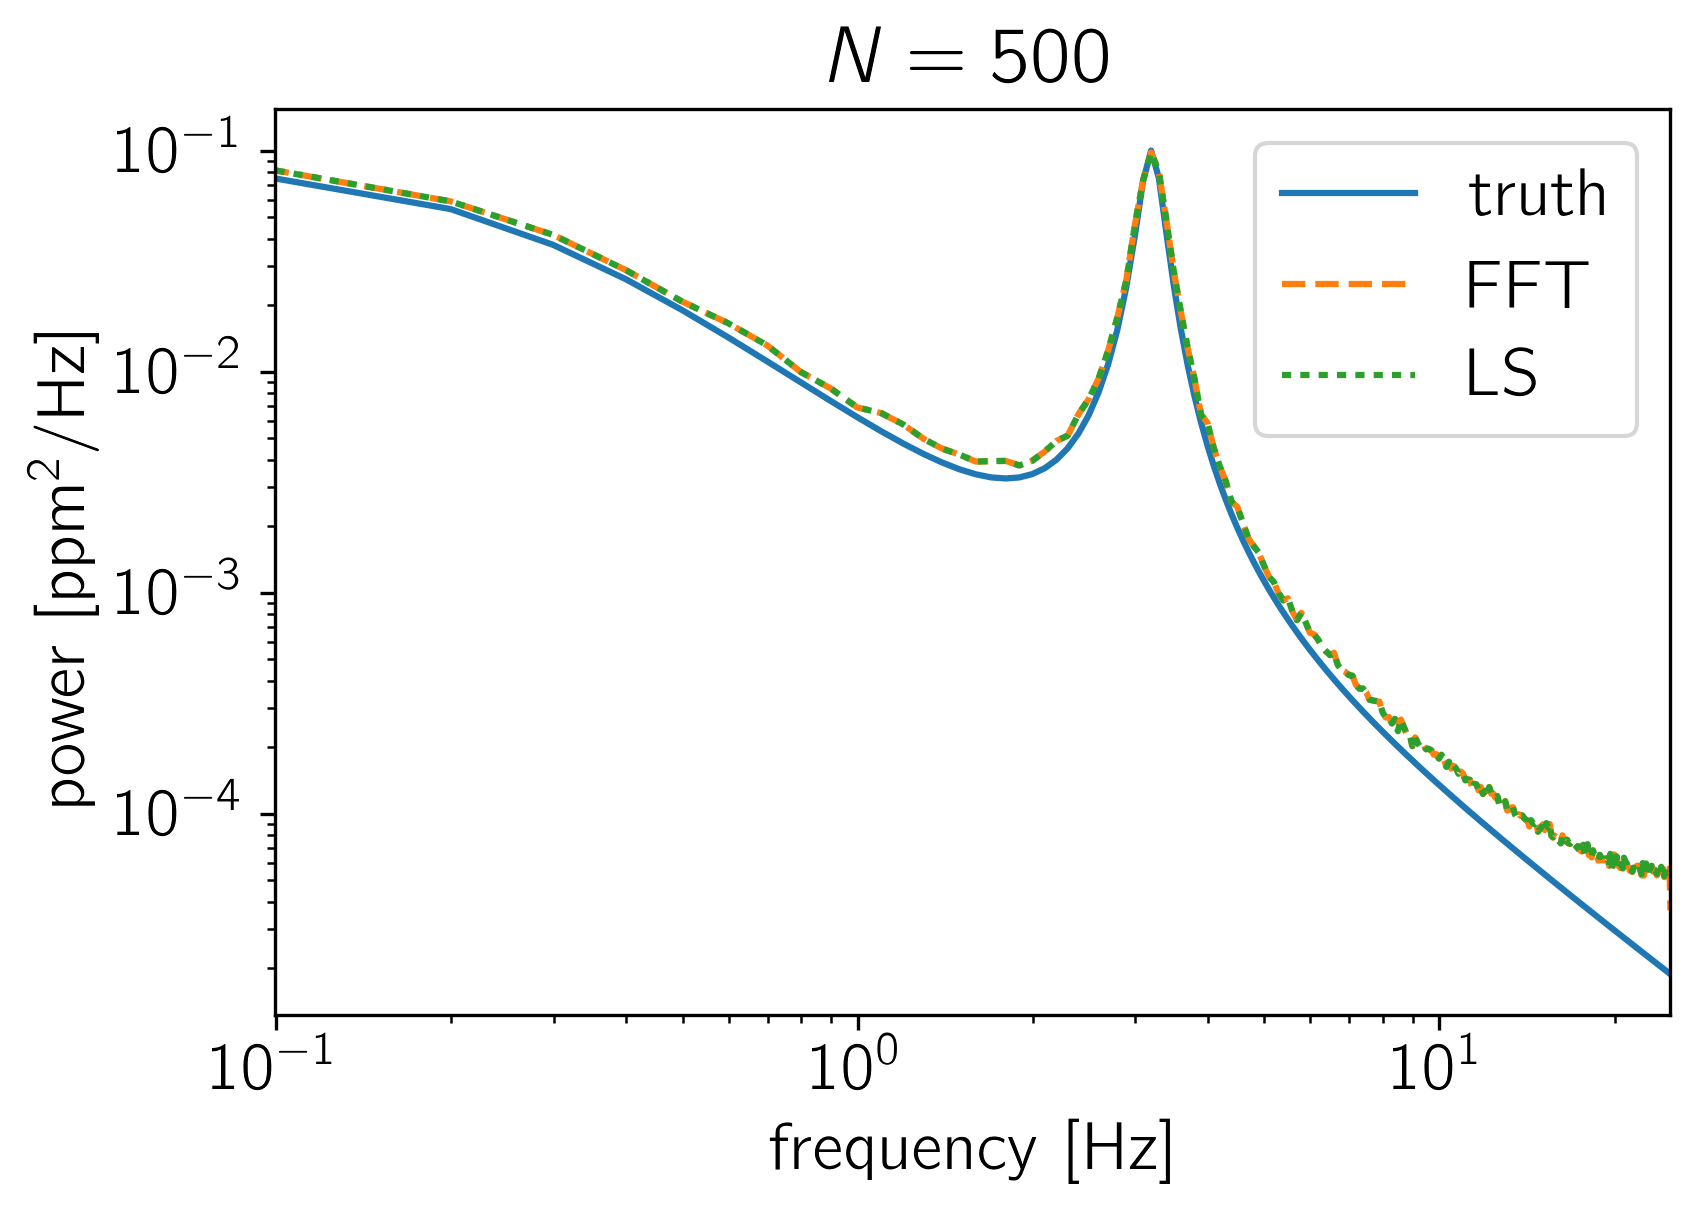

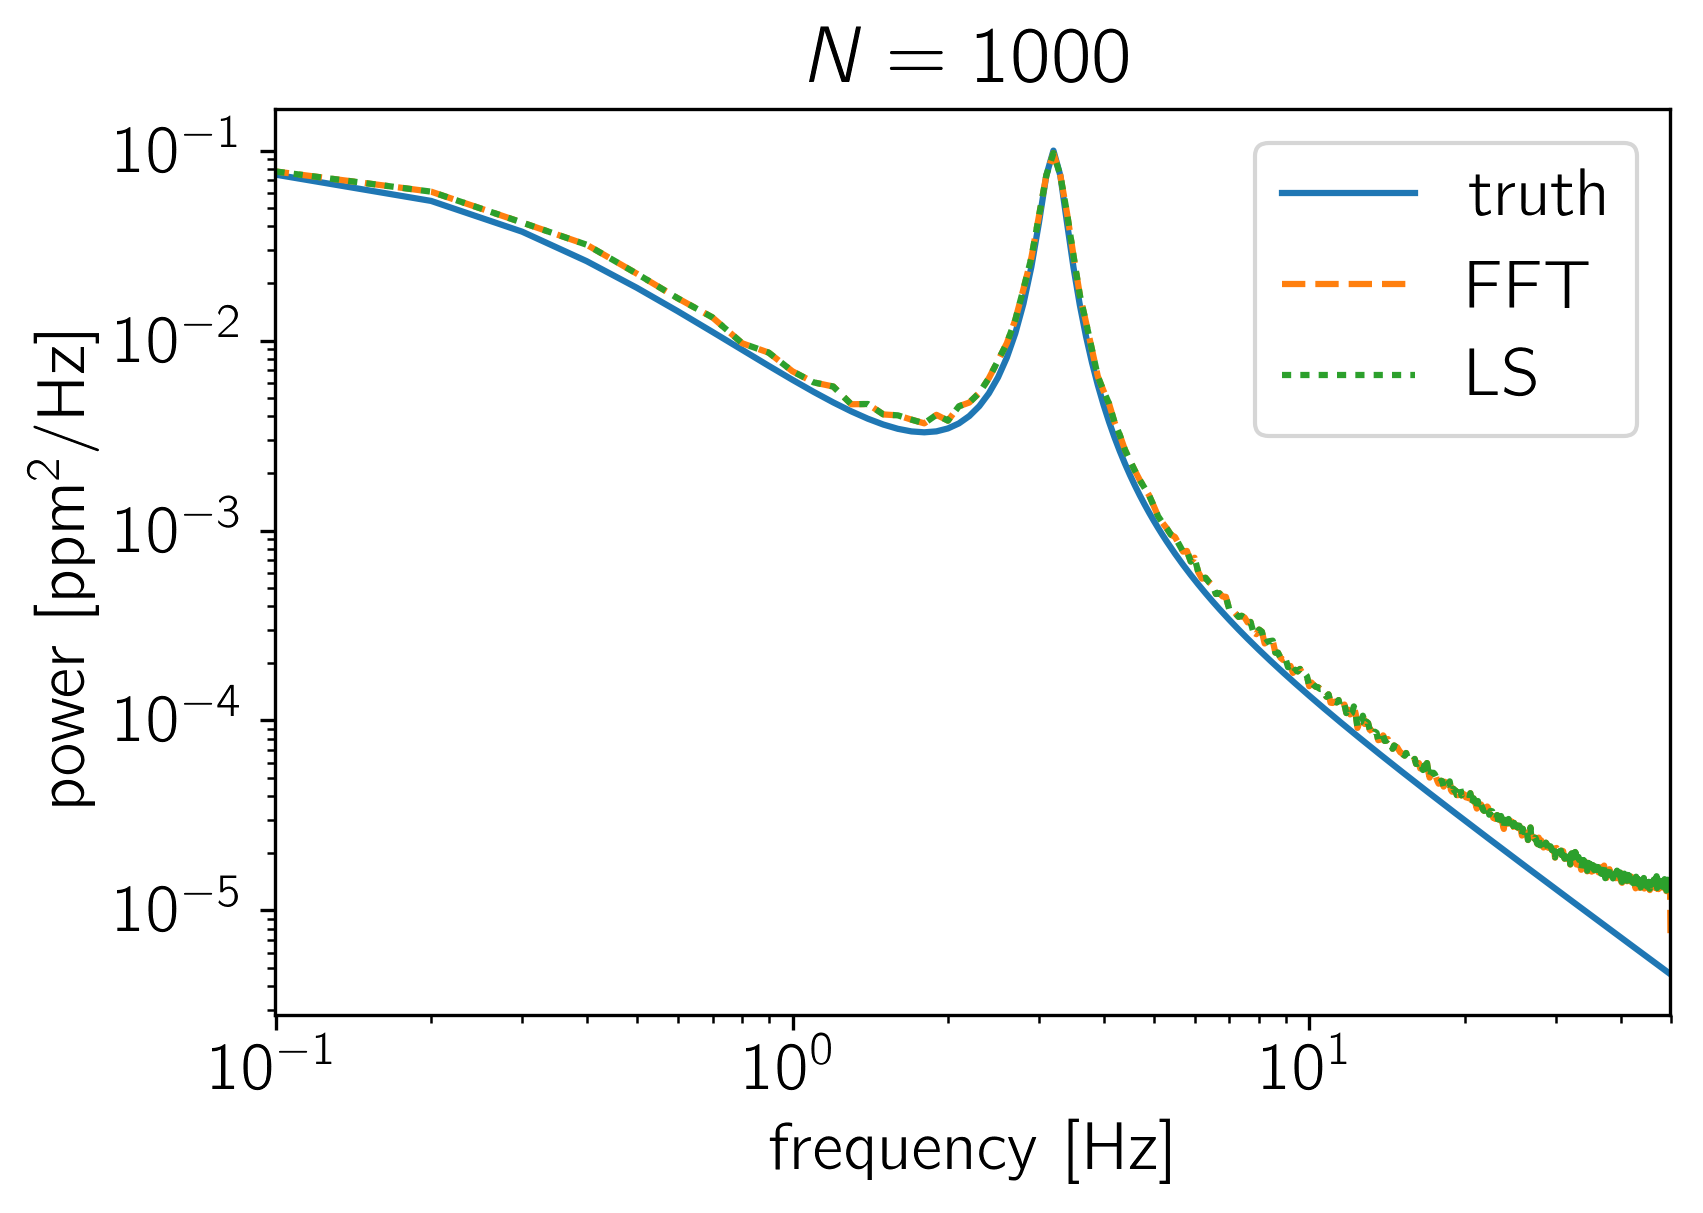

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

import celerite
from celerite import terms

def simulate_and_compute_psds(N, K=1500):
    # Set up a simple celerite model
    kernel = terms.RealTerm(0.1, 0.5) + terms.ComplexTerm(0.5, 0.05, 3.0)
    gp = celerite.GP(kernel)
    
    # Simulate K datasets with N points
    t = np.linspace(0, 10, N)
    gp.compute(t)
    np.random.seed(42)
    y = gp.sample(size=K)
    
    # Compute the FFT based power spectrum estimates
    f = np.fft.rfftfreq(len(t), t[1] - t[0])
    fft = np.array(list(map(np.fft.rfft, y)))
    fft *= np.conj(fft)
    
    # >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
    power_fft = fft.real / N**2

    # Compute the LS based power spectrum estimates
    power_ls = []
    for y0 in y:
        model = LombScargle(t, y0)
        power_ls.append(model.power(f[1:-1], method="fast", normalization="psd"))
    power_ls = np.array(power_ls)
    
    # >>> To get the LS based PSD in the correct units, normalize by N <<<
    power_ls /= N
    
    # Compute the true power spectrum
    # NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
    power_true = kernel.get_psd(2*np.pi*f)
    
    # >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
    power_true /= 2*np.pi
    
    # Let's plot the estimates of the PSD
    plt.figure()
    plt.plot(f, power_true, label="truth")
    plt.plot(f, np.median(power_fft, axis=0), "--", label="FFT")
    plt.plot(f[1:-1], np.median(power_ls, axis=0), ":", label="LS")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(f.min(), f.max())
    plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
    plt.xlabel("frequency [Hz]")
    plt.title("$N = {0}$".format(N))
    plt.legend()
    
simulate_and_compute_psds(500)
simulate_and_compute_psds(1000)